In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import math
%matplotlib inline

In [2]:
img_path = "./00_data/"

In [3]:
df = pd.read_csv(img_path+"BA_Total.csv")

In [4]:
df.head()

,원본 Folder,원본 No.,filename,성별,검사 시 나이,신장,체중,BMI,BA
0,BA(F-3yr)19명,001_F,org001.jpg,1,3.0,88.9,11.3,14.3,3.3
1,BA(F-3yr)19명,002_F,org002.jpg,1,3.0,95.9,13.5,14.7,1.8
2,BA(F-3yr)19명,003_F,org003.jpg,1,3.0,88.2,13.0,16.8,2.4
3,BA(F-3yr)19명,004_F,org004.jpg,1,3.2,88.7,12.9,16.4,2.3
4,BA(F-3yr)19명,005_F,org005.jpg,1,3.3,90.8,14.0,17.0,4.0


In [6]:
def show(img):
    plt.figure(figsize=(15, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = "gray")
    plt.show()

## 이미지 전처리

### 마스크 만들기

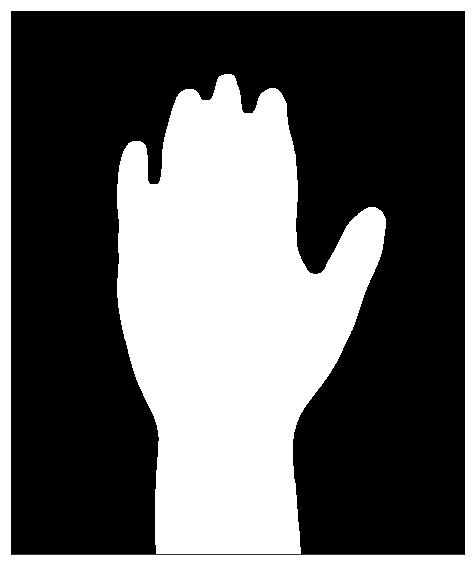

In [6]:
img = cv2.imread(img_path+"org001.jpg")

#마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환 01
img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

#블러 02
#블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
blur_k = int((img.mean()*0.5)//2)*2+1 
img = cv2.medianBlur(img, blur_k)

#threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환 03
img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#이미지 평균값을 기준으로 이진화 04
ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

#가장 큰 값의 컨투어로 마스크 만들기 05
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_cnt = max(contours, key=cv2.contourArea)
mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
mask = cv2.dilate(mask,k)

show(mask)

In [7]:
for i in range(len(df)):
    img = cv2.imread(img_path+"org{0:03d}.jpg".format(i+1))
    
    #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

    #블러
    blur_k = int((img.mean()*0.5)//2)*2+1 #블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
    img = cv2.medianBlur(img, blur_k)

    #threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환
    img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #이미지 평균값을 기준으로 이진화
    ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

    #가장 큰 값의 컨투어로 마스크 만들기
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)

    path = img_path+"../01_bit_mask/{0:03d}_01.jpg".format(i+1)
    cv2.imwrite(path, mask)

### 마스크 기준으로 위/왼/오른쪽 자르기

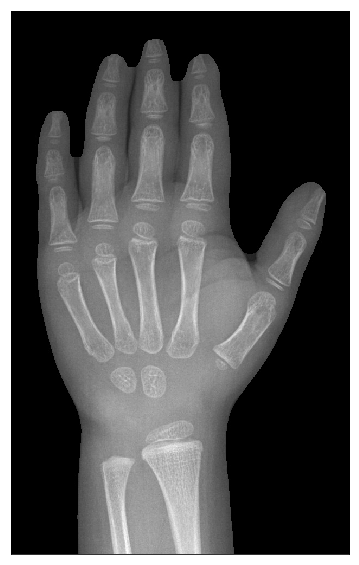

In [55]:
img = cv2.imread(img_path+"org001.jpg")
img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
height, width = img_.shape

#마스크 기준으로 위/왼/오른쪽 경계선 찾기
mask = cv2.imread(img_path+"../01_bit_mask/001_01.jpg", cv2.IMREAD_GRAYSCALE)

#테두리가 흰색인 경우를 고려해서, 테두리에서 5% 지점부터 경계점 찾기 시작
#경계점은 중간 부분(30~70%)에서 검은색(0)을 벗어난 지점을 기준으로 함
#위쪽
for y in range(int(height*0.05),height):
    if max(mask[y,int(width*0.3):int(width*0.7)]) > 0:
        start_y = y-int(height*0.05)
        break
#왼쪽
for x in range(int(width*0.05),width):
    if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
        start_x = x-int(width*0.05)
        break
#오른쪽
for x in range(int(width*0.95),-1,-1):
    if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
        end_x = x+int(width*0.05)
        break

#경계선 기준으로 이미지와 마스크 자름
img_ = img_[start_y:,start_x:end_x]
mask = mask[start_y:,start_x:end_x]

masked = cv2.bitwise_and(img_, mask)

show(masked)

In [7]:
for i in range(len(df)):

    img = cv2.imread(img_path+"org{0:03d}.jpg".format(i+1))
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img_.shape
    
    #마스크 기준으로 위/왼/오른쪽 경계선 찾기
    mask = cv2.imread(img_path+"../01_bit_mask/{0:03d}_01.jpg".format(i+1), cv2.IMREAD_GRAYSCALE)
    mask_list = mask.tolist()

    #테두리가 흰색인 경우를 고려해서, 테두리에서 5% 지점부터 경계점 찾기 시작
    #경계점은 중간 부분(30~70%)에서 검은색(0)을 벗어난 지점을 기준으로 함
    #위쪽
    for y in range(int(height*0.05),height):
        if max(mask[y,int(width*0.3):int(width*0.7)]) > 0:
            start_y = y-int(height*0.05)
            break
    #왼쪽
    for x in range(int(width*0.05),width):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            start_x = x-int(width*0.05)
            break
    #오른쪽
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break

    #경계선 기준으로 이미지와 마스크 자름
    img_ = img_[start_y:,start_x:end_x]
    mask = mask[start_y:,start_x:end_x]

    masked = cv2.bitwise_and(img_, mask)
    path = img_path+"../02_cut/{0:03d}_02.jpg".format(i+1)
    cv2.imwrite(path, masked)

### 마스크 기준으로 아래쪽 자르기 및 회전

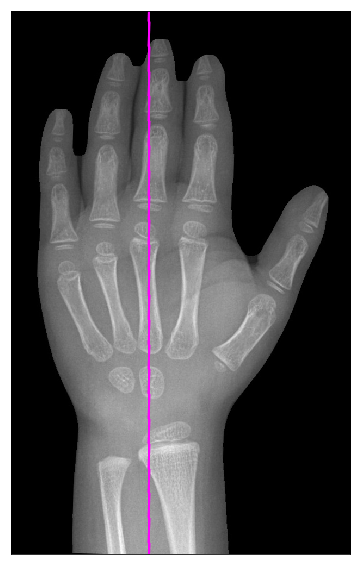

In [9]:
img = cv2.imread(img_path+"../02_cut/001_02.jpg")

###아래 테두리가 흰색 또는 검은색인 경우를 고려해서 아래부분 자르기
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
th_l = th.tolist()

cut_index = 0
# 맨 밑 처음이나 끝에 흰색이 나오면 검은색이 나오는 부분까지 자르기
if th_l[len(th_l)-1][-1] == 255 or th_l[len(th_l)-1][0] == 255:
    for i in reversed(range(len(th_l))):
        if th_l[i][0] == 0 and th_l[i][-1] == 0:
            cut_index = i
            break

# 맨 밑 처음이 검정색이면 흰색이 나오는 부분까지 자르기
if th_l[len(th_l)-1][0] == 0 or th_l[len(th_l)-1][-1] == 0:
    for i in reversed(range(len(th_l))):
        if th_l[i].count(255) > 0:
            cut_index = i
            break

if cut_index == 0:
    cut_index = len(th_l)

img = img[:(cut_index-1)]

###회전하기
h, w = img.shape[:2]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
th_l = th.tolist()

# 밑에서부터 처음으로 검은 색이 나오는 부분이 lower
for i in reversed(range(len(th_l))):
    if th_l[i][0] == 0:
        lower = i
        break

# 만약 맨 밑이 lower면 이미지의 90퍼센트 부분을 lower로 정의
if lower == h - 1:
    lower = int(len(th_l)*0.9)

# upper는 lower에서 5퍼센트만큼 올라간 부분
slice5 = int(len(th)*0.05)
upper = lower - slice5

# x, y좌표들은 이미지의 85퍼센트(upper)와 90퍼센트(lower) 부분의 손목 가운데 지점들
x,y = [],[]
for i in range(slice5):
    cnt = th_l[i + upper].count(255)
    index = th_l[i + upper].index(255)
    x.append([i+upper])
    y.append([int((index*2 + cnt - 1)/2)])

# x,y좌표로 단순선형회귀 그리기
model = LinearRegression()
model.fit(X=x,y=y)

# 선으로 표현
draw = cv2.line(img,(int(model.predict([[0]])),0),(int(model.predict([[h]])),h),(255,0,255),3)

# 회전
angle = math.atan2(h - 0, int(model.predict([[h]])) - int(model.predict([[0]])))*180/math.pi
M = cv2.getRotationMatrix2D((w/2,h/2),angle-90,1)
rotate = cv2.warpAffine(img, M, (w,h))

# 회전한 부분을 자르기
for i in range(len(th[-1])):
    if th[-1][i] == 255:
        start_x = i
        break

for i in range(len(th[-1])):
    if th[-1][i] == 255:
        end_x = i

s_point = h - int((int(model.predict([[h]])-start_x)) * math.tan(math.pi*((90-angle)/180)))
e_point = h - int((end_x - int(model.predict([[h]]))) * math.tan(math.pi*((angle-90)/180)))
point = min(s_point, e_point)

img = rotate[:point]

show(img)

In [10]:
for n in range(len(df)):
    img = cv2.imread(img_path+"../02_cut/{0:03d}_02.jpg".format(n+1))  

    ###아래 테두리가 흰색 또는 검은색인 경우를 고려해서 아래부분 자르기
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_l = th.tolist()

    cut_index = 0
    # 맨 밑 처음이나 끝에 흰색이 나오면 검은색이 나오는 부분까지 자르기
    if th_l[len(th_l)-1][-1] == 255 or th_l[len(th_l)-1][0] == 255:
        for i in reversed(range(len(th_l))):
            if th_l[i][0] == 0 and th_l[i][-1] == 0:
                cut_index = i
                break

    # 맨 밑 처음이 검정색이면 흰색이 나오는 부분까지 자르기
    if th_l[len(th_l)-1][0] == 0 or th_l[len(th_l)-1][-1] == 0:
        for i in reversed(range(len(th_l))):
            if th_l[i].count(255) > 0:
                cut_index = i
                break

    if cut_index == 0:
        cut_index = len(th_l)

    img = img[:(cut_index-1)]

    ###회전하기
    h, w = img.shape[:2]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_l = th.tolist()

    # 밑에서부터 처음으로 검은 색이 나오는 부분이 lower
    for i in reversed(range(len(th_l))):
        if th_l[i][0] == 0:
            lower = i
            break

    # 만약 맨 밑이 lower면 이미지의 90퍼센트 부분을 lower로 정의
    if lower == h - 1:
        lower = int(len(th_l)*0.9)

    # upper는 lower에서 5퍼센트만큼 올라간 부분
    slice5 = int(len(th)*0.05)
    upper = lower - slice5

    # x, y좌표들은 이미지의 85퍼센트(upper)와 90퍼센트(lower) 부분의 손목 가운데 지점들
    x,y = [],[]
    for i in range(slice5):
        cnt = th_l[i + upper].count(255)
        index = th_l[i + upper].index(255)
        x.append([i+upper])
        y.append([int((index*2 + cnt - 1)/2)])

    # x,y좌표로 단순선형회귀 그리기
    model = LinearRegression()
    model.fit(X=x,y=y)

    # 선으로 표현
#     draw = cv2.line(img,(int(model.predict([[0]])),0),(int(model.predict([[h]])),h),(255,0,255),3)

    # 회전
    angle = math.atan2(h - 0, int(model.predict([[h]])) - int(model.predict([[0]])))*180/math.pi
    M = cv2.getRotationMatrix2D((w/2,h/2),angle-90,1)
    rotate = cv2.warpAffine(img, M, (w,h))

    # 회전한 부분을 자르기
    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            start_x = i
            break

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            end_x = i

    s_point = h - int((int(model.predict([[h]])-start_x)) * math.tan(math.pi*((90-angle)/180)))
    e_point = h - int((end_x - int(model.predict([[h]]))) * math.tan(math.pi*((angle-90)/180)))
    point = min(s_point, e_point)

    img = rotate[:point]

    path = img_path+"../03_rotation/{0:03d}_03.jpg".format(n+1)
    cv2.imwrite(path, img)

### ROI

In [11]:
#중심점보다 오른쪽 아래에 있는 점들을 구하는 함수

def find_far_right_lower(mask):
    
    height, width = mask.shape[:2]
    
    #마스크 기준으로 컨투어 및 중심점 구하기
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    (x,y), radius = cv2.minEnclosingCircle(max_cnt)
    center = (int(x),int(y)) #중심점
    hull = cv2.convexHull(max_cnt, returnPoints = False)
    defects = cv2.convexityDefects(max_cnt, hull)

    far_right_lower = []
    for index in range(defects.shape[0]):
        s,e,f,d = defects[index,0]
        far = tuple(max_cnt[f][0])

        #far 좌표가 중심점보다 오른쪽 아래에 있고, 이미지 테두리보다 안쪽에 있는 점
        if (far[0] > center[0]) and (far[1] > center[1]) and (far[0] <= width*0.95) and (far[1] <= height*0.95):
            far_right_lower.append(far)
    
    return far_right_lower

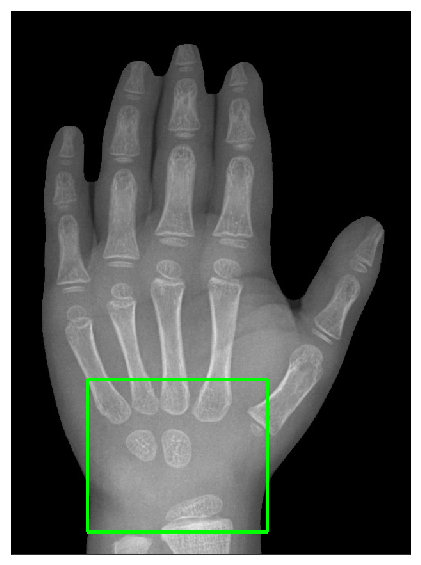

In [70]:
img = cv2.imread(img_path+"../03_rotation/001_03.jpg")
img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
height, width = img_.shape

#이미지의 아래에서부터 시작해서 화소 평균이 커지는(밝아지는) 경계선 찾기
start = int(height*0.95)  #아래 테두리가 밝은 경우를 고려해서 height*0.95부터 시작함
index = 0
k = 10 #10개 행씩 평균 구함
while True:
    pixel_lower = img_[start-k*(index+1):start-k*index,:].mean()
    pixel_upper = img_[start-k*(index+2):start-k*(index+1),:].mean()
    if pixel_upper - pixel_lower > 0:
        end_y = start-k*(index+1)
        break
    index += 1

img = img[:end_y]

#엄지-손목 경계점 기준으로 ROI
img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
height, width = img_.shape

ret, mask = cv2.threshold(img_, 10, 255, cv2.THRESH_BINARY)

far_right_lower = find_far_right_lower(mask)

#오른쪽 아래에 있는 점이 없는 경우, resize해서 함수 재실행
if len(far_right_lower) == 0:
    resize_height = 800
    resize_width = 600
    img = cv2.resize(img, (resize_height, resize_width), interpolation=cv2.INTER_AREA)
    mask = cv2.resize(mask, (resize_height, resize_width), interpolation=cv2.INTER_AREA)
    far_right_lower = find_far_right_lower(mask)

try:
    #추가한 far 좌표 중 가장 아래쪽에 있는 좌표(엄지 손가락과 손목 경계점) 기준으로, ROI 영역 구함
    max_far = max(far_right_lower, key = lambda x:x[1]) 
    end_x = max_far[0]
    end_y = int(max_far[1]*1.1) #1.1은 임의의 숫자. ROI를 아래쪽으로 확대하고 싶으면 숫자 늘리기.
    start_y = int(max_far[1]*0.78) #0.78은 임의의 숫자. ROI를 위쪽으로 확대하고 싶으면 숫자 줄이기.
    start_x = np.argmax(mask[max_far[1],:])
except:
    print(i+1)
    
cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (0,255,0), 3)

show(img)

In [71]:
for i in range(len(df)):
    img = cv2.imread(img_path+"../03_rotation/{0:03d}_03.jpg".format(i+1))
    
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    height, width = img_.shape    
    
    try:
        #이미지의 아래에서부터 시작해서 화소 평균이 커지는(밝아지는) 경계선 찾기
        start = int(height*0.95)  #아래 테두리가 밝은 경우를 고려해서 height*0.95부터 시작함
        index = 0
        k = 10 #10개 행씩 평균 구함
        while True:
            pixel_lower = img_[start-k*(index+1):start-k*index,:].mean()
            pixel_upper = img_[start-k*(index+2):start-k*(index+1),:].mean()
            if pixel_upper - pixel_lower > 0:
                end_y = start-k*(index+1)
                break
            index += 1

        img = img[:end_y]

        #엄지-손목 경계점 기준으로 ROI
        img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   

        ret, mask = cv2.threshold(img_, 10, 255, cv2.THRESH_BINARY)

        far_right_lower = find_far_right_lower(mask)

        #오른쪽 아래에 있는 점이 없는 경우, resize해서 함수 재실행
        if len(far_right_lower) == 0:
            resize_height = 800
            resize_width = 600
            img = cv2.resize(img, (resize_height, resize_width), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (resize_height, resize_width), interpolation=cv2.INTER_AREA)
            far_right_lower = find_far_right_lower(mask)

        #추가한 far 좌표 중 가장 아래쪽에 있는 좌표(엄지 손가락과 손목 경계점) 기준으로, ROI 영역 구함
        max_far = max(far_right_lower, key = lambda x:x[1]) 
        end_x = max_far[0]
        end_y = int(max_far[1]*1.1) #1.1은 임의의 숫자. ROI를 아래쪽으로 확대하고 싶으면 숫자 늘리기.
        start_y = int(max_far[1]*0.78) #0.78은 임의의 숫자. ROI를 위쪽으로 확대하고 싶으면 숫자 줄이기.
        start_x = np.argmax(mask[max_far[1],:])
    #         cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (0,255,0), 3)
        roi = img[start_y:end_y,start_x:end_x]

        path = img_path+"../04_roi/{0:03d}_04.jpg".format(i+1)
        cv2.imwrite(path, roi)
    
    except:
        print(i+1)

### ROI 뼈강조

In [72]:
def contrast(img, low, high):
    h, w = img.shape
    img_ = np.zeros(img.shape, dtype=np.uint8)
    
    for y in range(h):
        for x in range(w):
            temp = int( (255/(high-low)) * (img[y][x]-low) )
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp
    
    return img_

# def contrast(img, low, high):
    
#     img = img.astype("float")
#     img_ = (255 / (high - low)) * (img-low)
#     img_ = ((img_>0)*img_)
#     img_ = ((img_-255)>0)*255+img_*(img_<255)
#     img_ = img_.astype("uint8")  

#     return img_

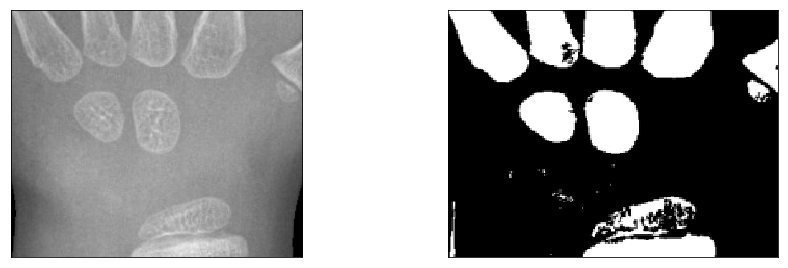

In [73]:
roi = cv2.imread(img_path+"../04_roi/001_04.jpg")

mask = roi.copy()
img = roi.copy()

###이진화
#마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2Lab)

#모폴로지
k = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
mask = cv2.morphologyEx(mask, cv2.MORPH_TOPHAT, k)

#블러
mask = cv2.GaussianBlur(mask, (15, 15), 0)

#threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환
mask = cv2.cvtColor(mask, cv2.COLOR_Lab2BGR)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

#이진화
ret, mask = cv2.threshold(mask, np.mean(mask), 255, cv2.THRESH_BINARY)

#컨투어
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(mask, contours, -1, (255,255,255), -1)


###강조
#모폴로지
k = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

#contrast
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if img.mean() <= 15:
    low = img.mean()*1.5
    high = img.mean()*1.6
elif img.mean() <= 20:
    low = img.mean()*1.5
    high = img.mean()*1.8
else:
    low = img.mean()*1.5
    high = img.mean()*2

img = contrast(img, low, high)

#컨투어
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (255,255,255), -1)

#마스크랑 비트 연산
img = cv2.bitwise_and(img, mask)

img = cv2.resize(img, (200, 150), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.xticks([])
plt.yticks([])
plt.imshow(roi, cmap = "gray")
plt.subplot(222)
plt.xticks([])
plt.yticks([])
plt.imshow(img, cmap = "gray")

In [74]:
for i in range(len(df)):
    
    roi = cv2.imread(img_path+"../04_roi/{0:03d}_04.jpg".format(i+1))

    img = roi.copy()

    ###이진화
    #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

    #모폴로지
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

    #블러
    img = cv2.GaussianBlur(img, (15, 15), 0)

    #threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환
    img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #이진화
    ret, mask = cv2.threshold(img, np.mean(img), 255, cv2.THRESH_BINARY)

    #컨투어
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, contours, -1, (255,255,255), -1)


    ###강조
    img = roi.copy()

    #모폴로지
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

    #contrast
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if img.mean() <= 15:
        low = img.mean()*1.5
        high = img.mean()*1.6
    elif img.mean() <= 20:
        low = img.mean()*1.5
        high = img.mean()*1.8
    else:
        low = img.mean()*1.5
        high = img.mean()*2

    img = contrast(img, low, high)

    #컨투어
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (255,255,255), -1)

    #마스크랑 비트 연산
    img = cv2.bitwise_and(img, mask)
    
    #크기 표준화
    img = cv2.resize(img, (200, 150), interpolation=cv2.INTER_AREA)

    path = img_path+"../05_roi_final/{0:03d}_05.jpg".format(i+1)
    cv2.imwrite(path, img)

In [75]:
for i in range(len(df)):
    
    roi = cv2.imread(img_path+"../04_roi/{0:03d}_04.jpg".format(i+1))

    img = roi.copy()

    ###이진화
    #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

    #모폴로지
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

    #블러
    img = cv2.GaussianBlur(img, (15, 15), 0)

    #threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환
    img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #이진화
    ret, mask = cv2.threshold(img, np.mean(img), 255, cv2.THRESH_BINARY)

    #컨투어
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, contours, -1, (255,255,255), -1)


    ###강조
    img = roi.copy()

    #모폴로지
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

    #contrast
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if img.mean() <= 15:
        low = img.mean()*1.5
        high = img.mean()*1.6
    elif img.mean() <= 20:
        low = img.mean()*1.5
        high = img.mean()*1.8
    else:
        low = img.mean()*1.5
        high = img.mean()*2

    img = contrast(img, low, high)

    #컨투어
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (255,255,255), -1)

    #마스크랑 비트 연산
    img = cv2.bitwise_and(img, mask)
    
#     크기 표준화
#     img = cv2.resize(img, (200, 150), interpolation=cv2.INTER_AREA)

    path = img_path+"../05_roi_final_notResize/{0:03d}_05.jpg".format(i+1)
    cv2.imwrite(path, img)